In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time


## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True 

##### set parent directory

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
# print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Updated Directory: /mnt/c/users/rjmay/code/research_ms


In [4]:
# os.chdir(os.getcwd() + "/code/research_ms")


### Simulation stage

In [5]:
from modules.multi_bounds_v2 import bounds_class
from modules.Bhatt_knn_func import knn_num_calc

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
mean_sep = np.linspace(0, 5, 10000 , endpoint = True)


In [7]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 8 + dx, dx)
    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)
    fmin = np.minimum(f0, f1)
    BER = 0.5 * np.sum(fmin * dx)
    exact.append(BER)

#     print("BER 2d:", BER)

In [8]:
x = np.linspace(0,.5, 21, endpoint = True) ## this is the desired mean BER points to be calculated at 


new_mean_sep = [] 
for j in x:
    index = (np.abs(j - np.array(exact) )).argmin()
    new_mean_sep.append(mean_sep[index])

In [9]:
mean_sep = new_mean_sep

In [10]:
bound_obj_lst = []

bound_obj_lst2 = []


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:

    MC_num = 500

    for i in mean_sep:

        start = time.time()

        mean1 = np.zeros(8)
        covariance1 = np.identity(8)
        mean2 = np.zeros(8)
        mean2[0] = i
        covariance2= np.identity(8)
        
        
        sample_size= 100
        n0, n1 = sample_size, sample_size
        
        k = knn_num_calc(n0, len(mean1))

        
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]

        bounds = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, k_nn = k )
        
        bound_obj_lst.append(bounds)
        
        sample_size= 500
               
        
        n0, n1 = sample_size, sample_size
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]
        k = knn_num_calc(n0, len(mean1))
        
        bounds2 = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, k_nn = k )

        bound_obj_lst2.append(bounds2)
        
        
        end = time.time()
        
        print("done with ", i, " in ",  end -start )



USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [11]:
file_path = 'sim_data/means_sep_as_BER_v2.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst, bound_obj_lst2


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Loaded object successfully


## Using the data

may or not be pickled. 

In [12]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 8 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

#     print("BER 2d:", BER)

### Plotting using sample size 100

In [13]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

tight_l = []
tight_u = []

Bha_knn_l= []
Bha_knn_u =[]
Mah_u =[]

for obj in bound_obj_lst:
    a,b = obj.get_bounds_dp()
    dp_l.append(np.mean(a))
    dp_u.append(np.mean(b))
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(np.mean(a))
    Bha_u.append(np.mean(b))
    
    a, b = obj.get_bounds_tight()
    tight_l.append(np.mean(a))
    tight_u.append(np.mean(b))

    a,b = obj.get_bounds_Bha_knn()
    Bha_knn_l.append(np.mean(a))
    Bha_knn_u.append(np.mean(b))
    
    a= obj.get_upper_Maha()
    Mah_u.append(np.mean(a))
    
    

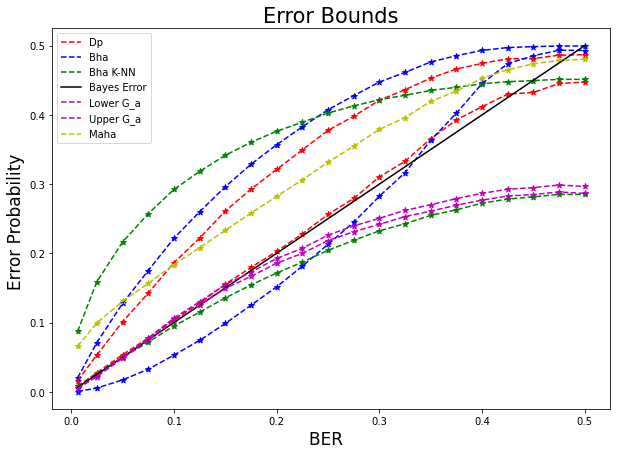

In [14]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)


ax.plot(exact, dp_l, 'r--', label='Dp')
ax.plot(exact, dp_u, 'r--')

ax.scatter(exact, dp_l, color='r', marker='*')
ax.scatter(exact, dp_u, color ='r', marker ='*' )

ax.plot(exact, Bha_l, 'b--', label='Bha')
ax.plot(exact, Bha_u, 'b--')
ax.scatter(exact, Bha_u, color='b', marker='*')
ax.scatter(exact, Bha_l, color ='b', marker ='*' )


ax.plot(exact, Bha_knn_l, 'g--')
ax.plot(exact, Bha_knn_u, 'g--', label='Bha K-NN')
ax.scatter(exact, Bha_knn_u, color='g', marker='*')
ax.scatter(exact, Bha_knn_l, color ='g', marker ='*' )


ax.plot(exact, exact, 'k', label='Bayes Error')

ax.plot(exact, tight_l, 'm--', label='Lower G_a')
ax.plot(exact, tight_u, 'm--', label='Upper G_a')
ax.scatter(exact, tight_l, color='m', marker='*')
ax.scatter(exact, tight_u, color ='m', marker ='*' )

ax.plot(exact, Mah_u, 'y--', label='Maha')
ax.scatter(exact, Mah_u, color ='y', marker ='*' )

ax.set_xlabel("BER  ", fontsize = fs)
ax.set_ylabel("Error Probability ", fontsize=fs)
ax.set_title("Error Bounds", fontsize = fs +4)
ax.legend()
# plt.savefig("bounds.png",facecolor=(1,1,1,1))

plt.show()


In [34]:
validity_dp_l = np.zeros(len(mean_sep))
validity_dp_u = np.zeros(len(mean_sep))

validity_Bha_l = np.zeros(len(mean_sep))
validity_Bha_u =  np.zeros(len(mean_sep))

validity_tight_l = np.zeros(len(mean_sep))
validity_tight_u =  np.zeros(len(mean_sep))

validity_Bha_knn_l = np.zeros(len(mean_sep))
validity_Bha_knn_u =  np.zeros(len(mean_sep))


MC_num = bound_obj_lst[0].get_MC_num()


for i in range(len(mean_sep)):
    BER = exact[i]
    Bha_l_temp, Bha_u_temp = bound_obj_lst[i].get_bounds_Bha()
    dp_l_temp, dp_u_temp = bound_obj_lst[i].get_bounds_dp()
    tight_l_temp, tight_u_temp = bound_obj_lst[i].get_bounds_tight()
    Bha_knn_l_temp, Bha_knn_u_temp = bound_obj_lst[i].get_bounds_Bha_knn()
    
    for j in range(MC_num):
        if Bha_l_temp[j] < BER:
            validity_Bha_l[i] += 1
        if Bha_u_temp[j] > BER:
            validity_Bha_u[i] += 1
    
        if Bha_knn_l_temp[j] < BER:
            validity_Bha_knn_l[i] += 1
        if Bha_knn_u_temp[j] > BER:
            validity_Bha_knn_u[i] += 1    

        if dp_l_temp[j] < BER:
            validity_dp_l[i] += 1
        if dp_u_temp[j] > BER:
            validity_dp_u[i] += 1
        if tight_l_temp[j] < BER:
            validity_tight_l[i] += 1
        if tight_u_temp[j]> BER:
            validity_tight_u[i] += 1


In [37]:
validity_lst  =[]
for i in range(len(exact)):
    validity_lst.append(bound_obj_lst[i].validity(exact[2]))

In [40]:
import pandas as pd
df = pd.DataFrame(validity_lst, index = exact)
df

,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper
0.006210,1.000,0.000,1.000,0.000,1.000,1.0,1.000,0.000,0.994
0.025001,0.968,0.612,1.000,0.882,1.000,1.0,0.996,0.008,1.000
0.049994,0.376,0.978,1.000,1.000,0.514,1.0,0.604,0.442,1.000
0.074984,0.044,1.000,0.944,1.000,0.028,1.0,0.130,0.892,1.000
0.099987,0.002,1.000,0.434,1.000,0.000,1.0,0.012,0.992,1.000
0.124997,0.000,1.000,0.074,1.000,0.000,1.0,0.004,0.996,1.000
0.150019,0.000,1.000,0.004,1.000,0.000,1.0,0.000,1.000,1.000
0.174999,0.000,1.000,0.000,1.000,0.000,1.0,0.000,1.000,1.000
0.200010,0.000,1.000,0.000,1.000,0.000,1.0,0.000,1.000,1.000
0.225027,0.000,1.000,0.000,1.000,0.000,1.0,0.000,1.000,1.000


(0.376, 0.978)

In [17]:
# print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

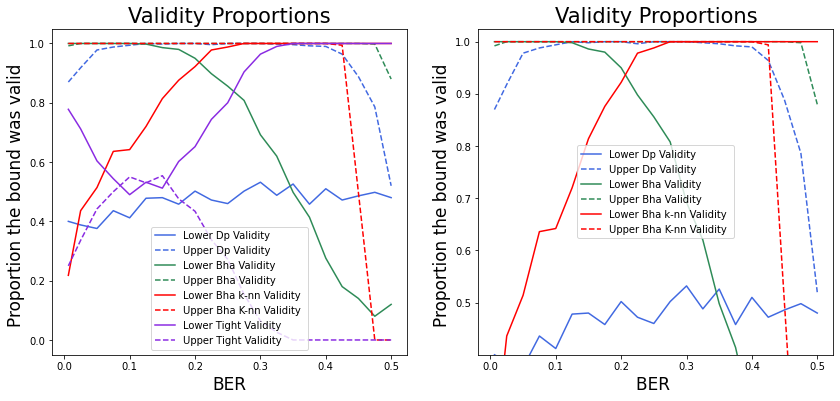

In [18]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(exact, validity_dp_l/ MC_num, 'royalblue',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'royalblue', linestyle = 'dashed', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'seagreen', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'seagreen', linestyle = 'dashed', label='Upper Bha Validity ')

ax.plot(exact, validity_Bha_knn_l/ MC_num,'r', label='Lower Bha k-nn Validity ')
ax.plot(exact, validity_Bha_knn_u/ MC_num, 'r--',  label='Upper Bha K-nn Validity ')

ax.plot(exact, validity_tight_l/ MC_num, 'blueviolet', label='Lower Tight Validity ')
ax.plot(exact, validity_tight_u/ MC_num, 'blueviolet', linestyle = 'dashed', label='Upper Tight Validity ')


ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(exact, validity_dp_l/ MC_num, 'royalblue',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'royalblue', linestyle = 'dashed', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'seagreen', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'seagreen', linestyle = 'dashed', label='Upper Bha Validity ')

ax.plot(exact, validity_Bha_knn_l/ MC_num,'r', label='Lower Bha k-nn Validity ')
ax.plot(exact, validity_Bha_knn_u/ MC_num, 'r--',  label='Upper Bha K-nn Validity ')

# ax.plot(exact, validity_tight_l/ MC_num, 'blueviolet', label='Lower Tight Validity ')
# ax.plot(exact, validity_tight_u/ MC_num, 'blueviolet', linestyle = 'dashed', label='Upper Tight Validity ')
ax.set_ylim([.4, 1.025])
ax.set_yticks(np.linspace(.5,1,6))


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


# plt.savefig("proportions.png",facecolor=(1,1,1,1))
plt.show()

### Plotting using sample size 500

In [19]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

tight_l = []
tight_u = []

Bha_knn_l= []
Bha_knn_u =[]
Mah_u =[]

for obj in bound_obj_lst2:
    a,b = obj.get_bounds_dp()
    dp_l.append(np.mean(a))
    dp_u.append(np.mean(b))
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(np.mean(a))
    Bha_u.append(np.mean(b))
    
    a, b = obj.get_bounds_tight()
    tight_l.append(np.mean(a))
    tight_u.append(np.mean(b))

    a,b = obj.get_bounds_Bha_knn()
    Bha_knn_l.append(np.mean(a))
    Bha_knn_u.append(np.mean(b))
    
    a= obj.get_upper_Maha()
    Mah_u.append(np.mean(a))
    
    

In [20]:
dpi = 400
fs =17

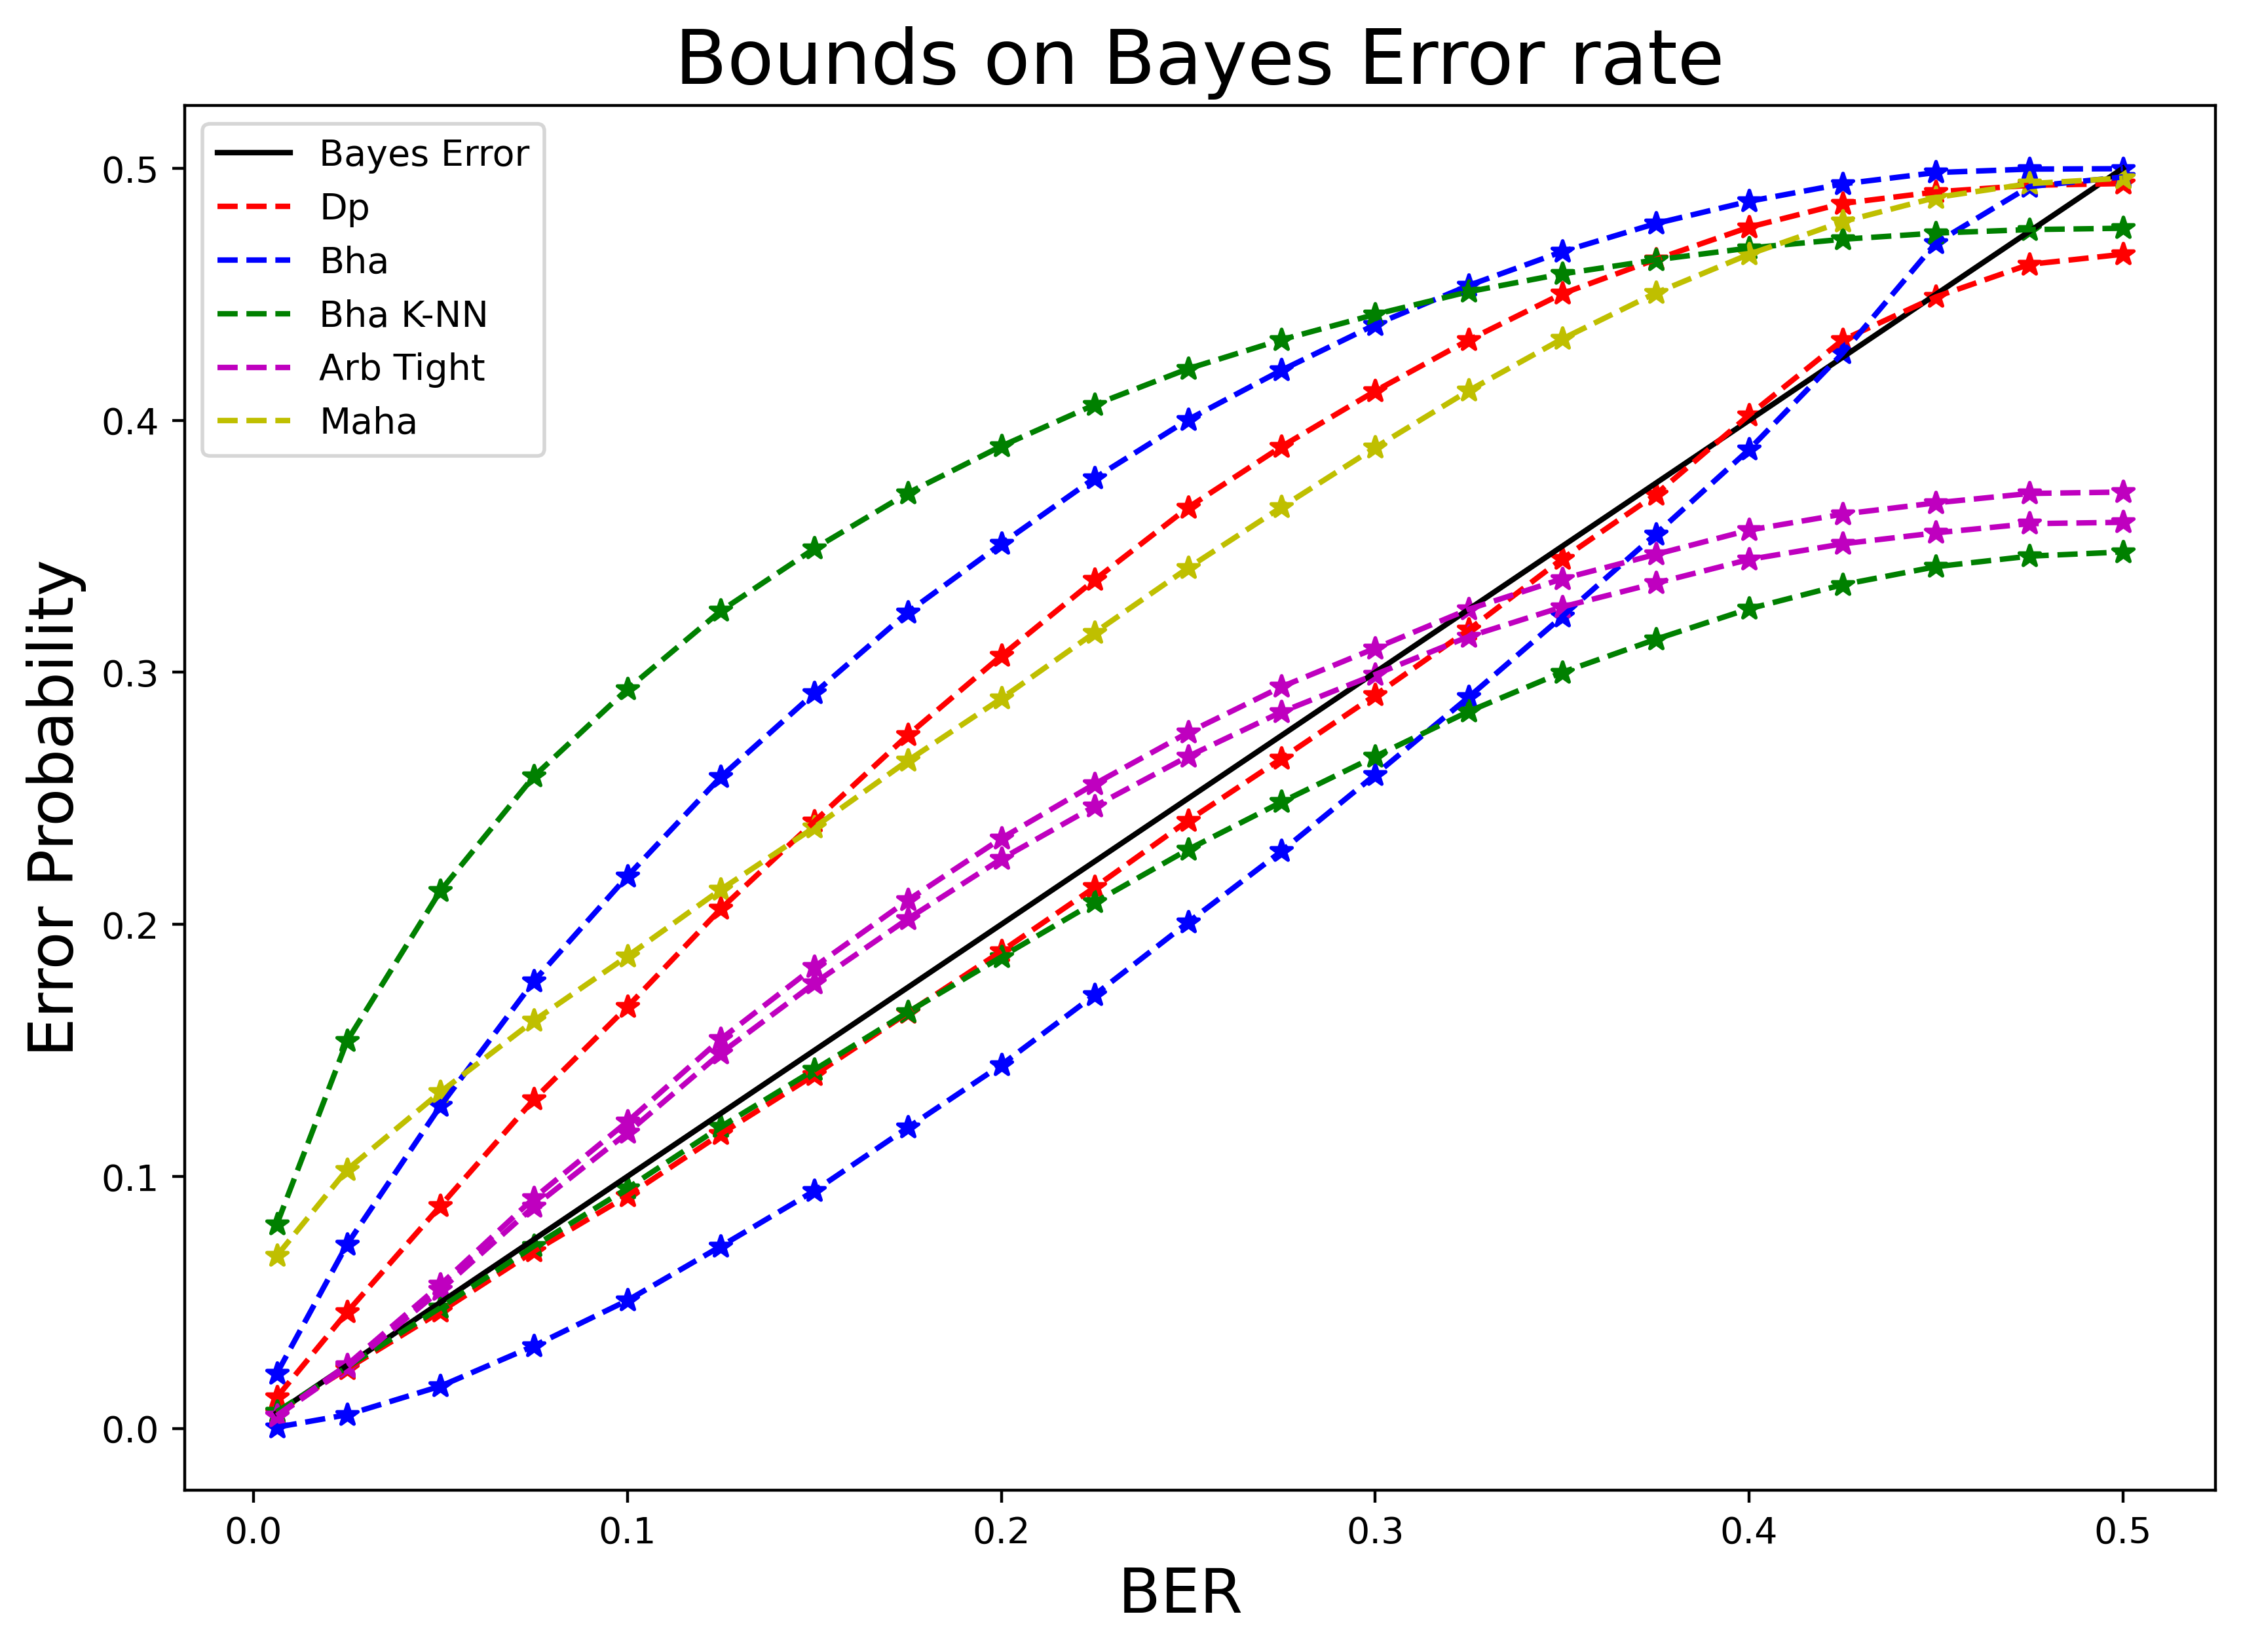

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), dpi = dpi)


ax.plot(exact, exact, 'k', label='Bayes Error')

ax.plot(exact, dp_l, 'r--', label='Dp')
ax.plot(exact, dp_u, 'r--')

ax.scatter(exact, dp_l, color='r', marker='*')
ax.scatter(exact, dp_u, color ='r', marker ='*' )

ax.plot(exact, Bha_l, 'b--', label='Bha')
ax.plot(exact, Bha_u, 'b--')
ax.scatter(exact, Bha_u, color='b', marker='*')
ax.scatter(exact, Bha_l, color ='b', marker ='*' )


ax.plot(exact, Bha_knn_l, 'g--')
ax.plot(exact, Bha_knn_u, 'g--', label='Bha K-NN')
ax.scatter(exact, Bha_knn_u, color='g', marker='*')
ax.scatter(exact, Bha_knn_l, color ='g', marker ='*' )


ax.plot(exact, tight_l, 'm--', label='Arb Tight')
ax.plot(exact, tight_u, 'm--')
ax.scatter(exact, tight_l, color='m', marker='*')
ax.scatter(exact, tight_u, color ='m', marker ='*' )

ax.plot(exact, Mah_u, 'y--', label='Maha')
ax.scatter(exact, Mah_u, color ='y', marker ='*' )

ax.set_xlabel("BER  ", fontsize = fs)
ax.set_ylabel("Error Probability ", fontsize=fs)
ax.set_title("Bounds on Bayes Error rate", fontsize = fs +4)
ax.legend()
# plt.savefig("BER_V2.jpeg",facecolor=(1,1,1,1))

plt.show()


In [22]:
validity_dp_l = np.zeros(len(mean_sep))
validity_dp_u = np.zeros(len(mean_sep))

validity_Bha_l = np.zeros(len(mean_sep))
validity_Bha_u =  np.zeros(len(mean_sep))

validity_tight_l = np.zeros(len(mean_sep))
validity_tight_u =  np.zeros(len(mean_sep))

validity_Bha_knn_l = np.zeros(len(mean_sep))
validity_Bha_knn_u =  np.zeros(len(mean_sep))

validity_Maha =  np.zeros(len(mean_sep))


MC_num = bound_obj_lst2[1].get_MC_num()


for i in range(len(mean_sep)):
    BER = exact[i]
    Bha_l_temp, Bha_u_temp = bound_obj_lst2[i].get_bounds_Bha()
    dp_l_temp, dp_u_temp = bound_obj_lst2[i].get_bounds_dp()
    tight_l_temp, tight_u_temp = bound_obj_lst2[i].get_bounds_tight()
    Bha_knn_l_temp, Bha_knn_u_temp = bound_obj_lst2[i].get_bounds_Bha_knn()
    Maha_u_temp = bound_obj_lst2[i].get_upper_Maha()
    
    for j in range(MC_num):
        if Bha_l_temp[j] < BER:
            validity_Bha_l[i] += 1
        if Bha_u_temp[j] > BER:
            validity_Bha_u[i] += 1
    
        if Bha_knn_l_temp[j] < BER:
            validity_Bha_knn_l[i] += 1
        if Bha_knn_u_temp[j] > BER:
            validity_Bha_knn_u[i] += 1    

        if dp_l_temp[j] < BER:
            validity_dp_l[i] += 1
        if dp_u_temp[j] > BER:
            validity_dp_u[i] += 1
        if tight_l_temp[j] < BER:
            validity_tight_l[i] += 1
        if tight_u_temp[j]> BER:
            validity_tight_u[i] += 1
        if Maha_u_temp[j]> BER:
            validity_Maha[i] += 1


In [23]:
# print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

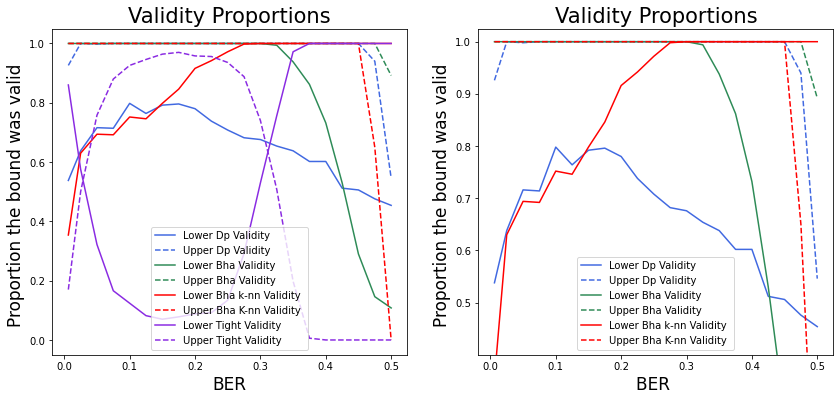

In [24]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(exact, validity_dp_l/ MC_num, 'royalblue',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'royalblue', linestyle = 'dashed', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'seagreen', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'seagreen', linestyle = 'dashed', label='Upper Bha Validity ')

ax.plot(exact, validity_Bha_knn_l/ MC_num,'r', label='Lower Bha k-nn Validity ')
ax.plot(exact, validity_Bha_knn_u/ MC_num, 'r--',  label='Upper Bha K-nn Validity ')

ax.plot(exact, validity_tight_l/ MC_num, 'blueviolet', label='Lower Tight Validity ')
ax.plot(exact, validity_tight_u/ MC_num, 'blueviolet', linestyle = 'dashed', label='Upper Tight Validity ')


ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(exact, validity_dp_l/ MC_num, 'royalblue',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'royalblue', linestyle = 'dashed', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'seagreen', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'seagreen', linestyle = 'dashed', label='Upper Bha Validity ')

ax.plot(exact, validity_Bha_knn_l/ MC_num,'r', label='Lower Bha k-nn Validity ')
ax.plot(exact, validity_Bha_knn_u/ MC_num, 'r--',  label='Upper Bha K-nn Validity ')

# ax.plot(exact, validity_tight_l/ MC_num, 'blueviolet', label='Lower Tight Validity ')
# ax.plot(exact, validity_tight_u/ MC_num, 'blueviolet', linestyle = 'dashed', label='Upper Tight Validity ')
ax.set_ylim([.4, 1.025])
ax.set_yticks(np.linspace(.5,1,6))


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


# plt.savefig("proportions.png",facecolor=(1,1,1,1))
plt.show()

Upper bound Validity

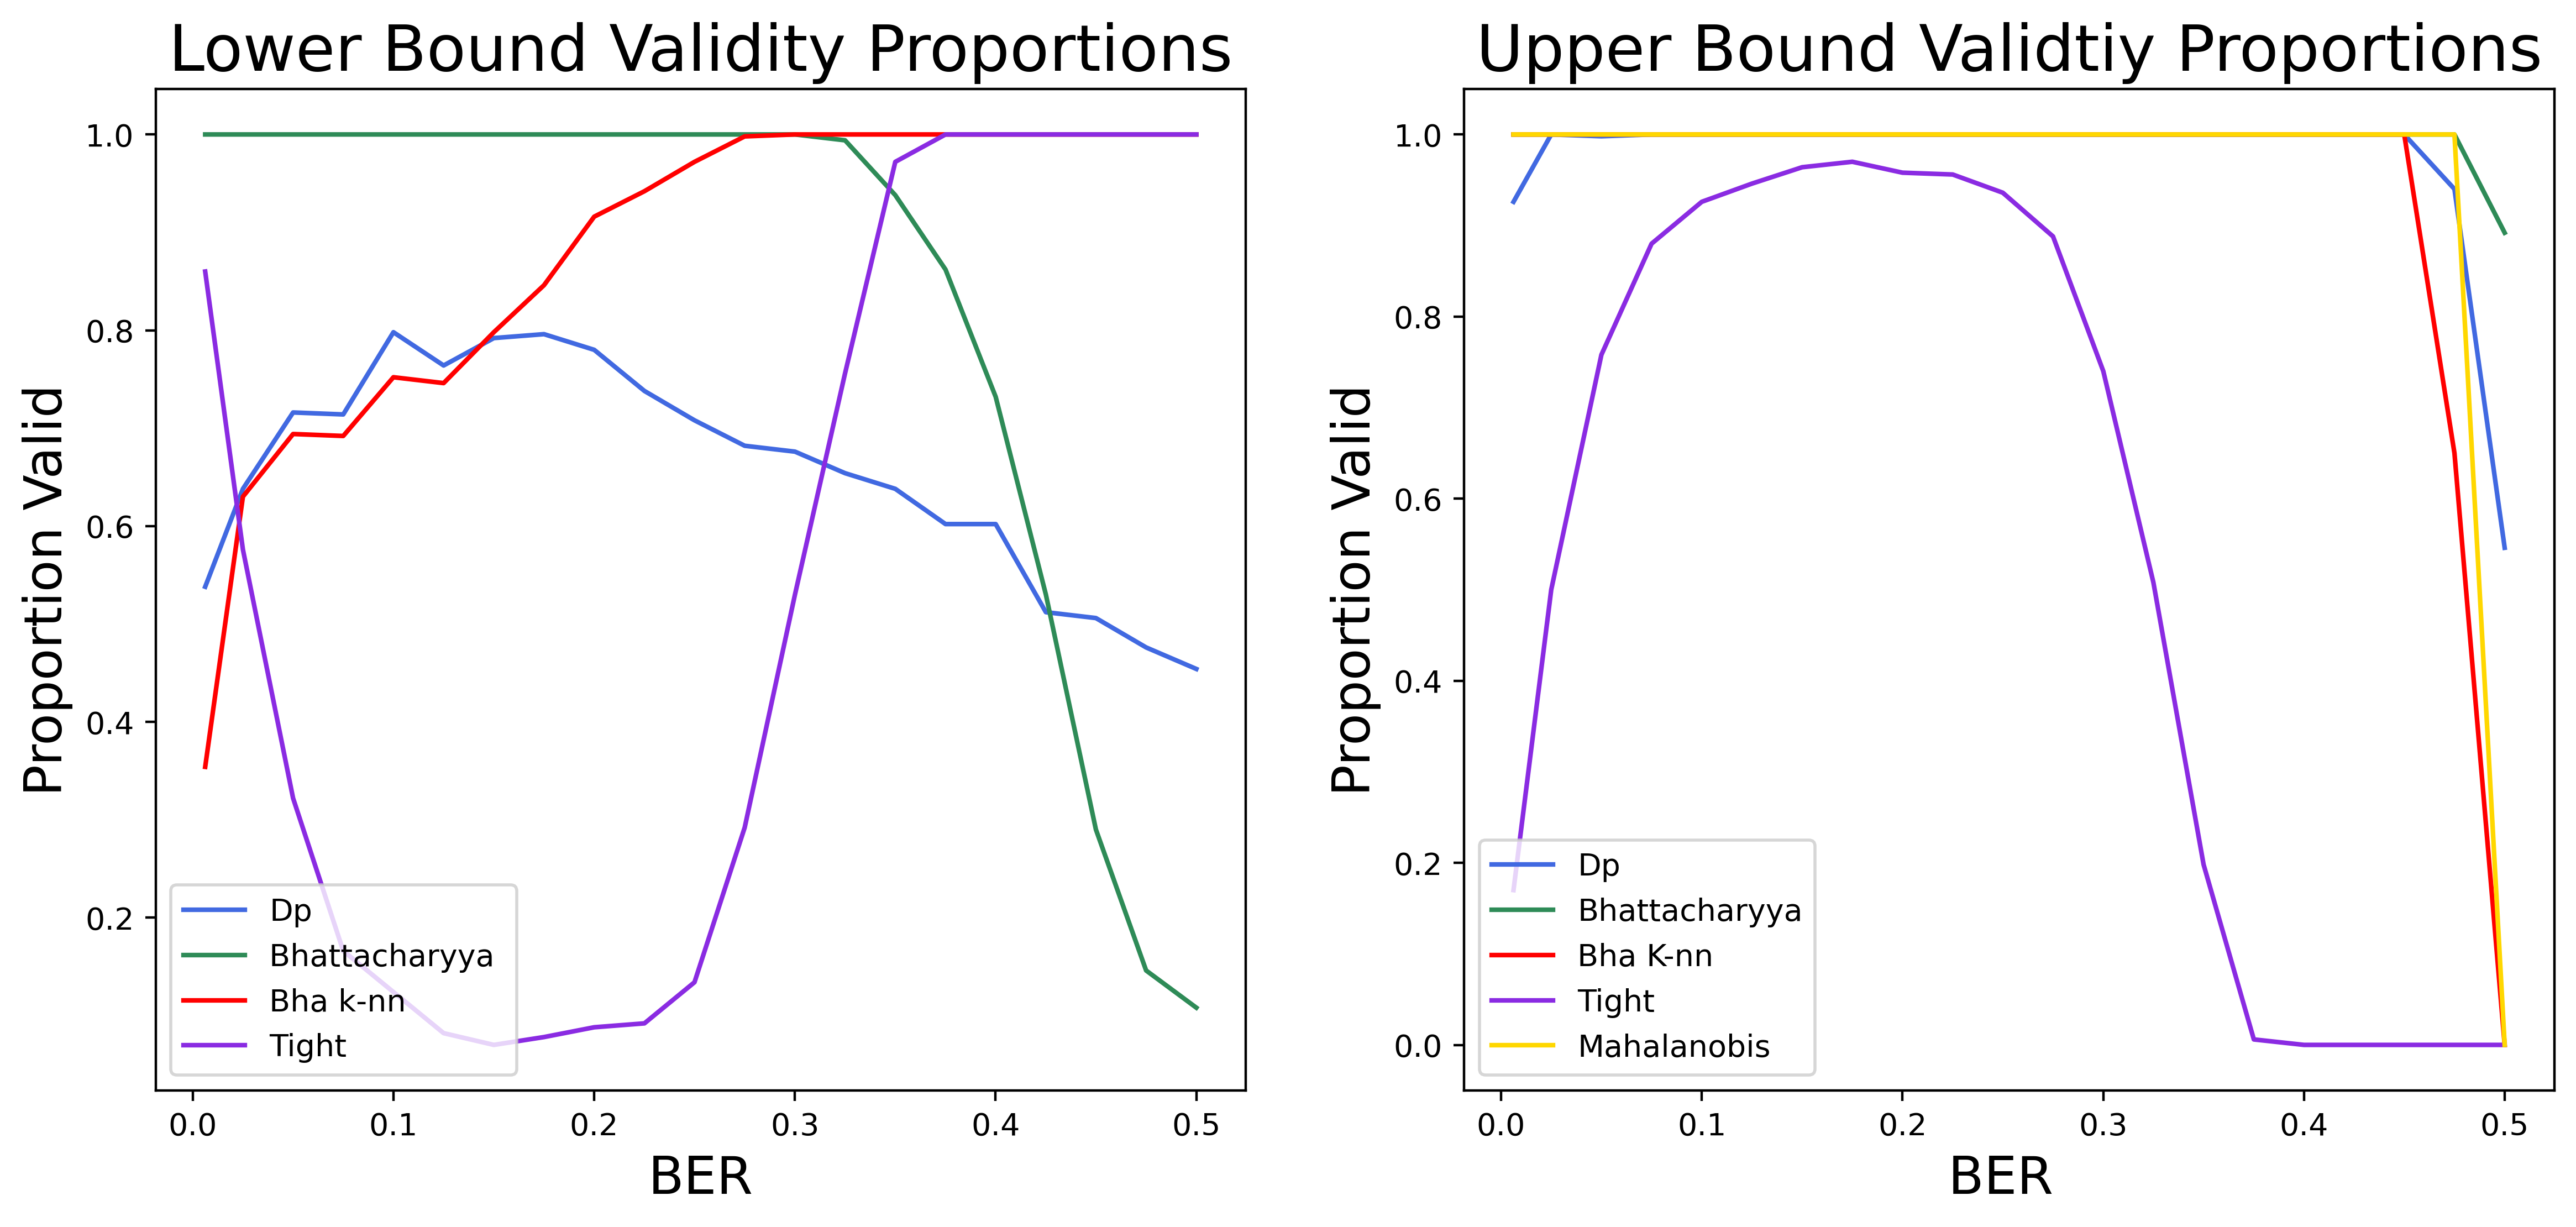

In [25]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), dpi = dpi)

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(exact, validity_dp_l/ MC_num, 'royalblue',  label='Dp')

ax.plot(exact, validity_Bha_l/ MC_num,'seagreen', label='Bhattacharyya ')

ax.plot(exact, validity_Bha_knn_l/ MC_num,'r', label='Bha k-nn ')

ax.plot(exact, validity_tight_l/ MC_num, 'blueviolet', label='Tight ')


ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend(loc=3)



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(exact, validity_dp_u/ MC_num, 'royalblue',  label='Dp')

ax.plot(exact, validity_Bha_u/ MC_num, 'seagreen', label='Bhattacharyya')

ax.plot(exact, validity_Bha_knn_u/ MC_num, 'r', label='Bha K-nn  ')

ax.plot(exact, validity_tight_u/ MC_num, 'blueviolet',label='Tight ')
ax.plot(exact, validity_Maha/ MC_num, 'gold', label= "Mahalanobis")

# ax.set_ylim([.4, 1.025])
# ax.set_yticks(np.linspace(.5,1,6))


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Upper Bound Validtiy Proportions" , fontsize = fs +4)
ax.legend(loc=3)


# plt.savefig("proportions_v2.jpeg",facecolor=(1,1,1,1))
plt.show()